In [4]:
# Importing modules used in the lecture
import numpy as np
from numpy import cos, sin, tan, pi, exp
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.io import wavfile
from IPython.display import Audio

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib widget

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Analysis of vibration signals, and use of FIR filters for envelope detection

* **Course AIS2201 - Signal Processing**
* **Week 46, 2024**
* **Lecturer: Kai Erik Hoff**

# Topics

* Bearing fault diagnosis as a usecase for envelope detection

* Use of FIR filters for envelope detection (the Hilbert Transform)

* The envelope spectrum

# Scenario:

* Ball bearing with inner race fault
<img src="figures/RollingElementBearingFaultDiagnosisExample_01.png" align="center" style="width: 60%; margin-left:100px">

* Ballpass Frequency, inner race (BPFI):
$$\text{BPFI} = \frac{fr}{2}\left(1-\frac{d}{D}\right)$$
    * $fr$ is "shaft speed" (rotations per second)

* A fault on the inner race should be visible in frequency analysis, as frequency components appearing at the BPFI frequency.

# Vibration signal analysis in practice

* We load a signal from dataset

In [6]:
from scipy.io import loadmat
file_data = loadmat("../data/vibration_bearing_data.mat", squeeze_me=True)
x = file_data['gs']
fs = file_data['sr']
t = np.arange(len(x))/fs
rate = file_data['rate']
BPFI = file_data['BPFI']

print(f"Shaft speed: {rate}\nBPFI: {BPFI}")

Shaft speed: 25
BPFI: 118.875


* Plot the Power Spectral Density

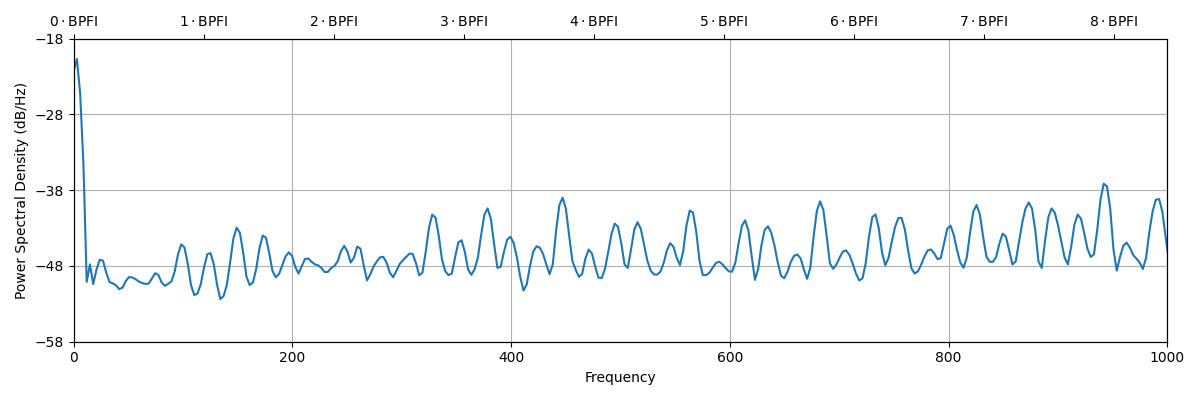

In [33]:
winsize=8192
f_max= 1000
plt.close(1);plt.figure(1, figsize=(12,4))
plt.psd(x, 
        NFFT=winsize,
        noverlap=winsize//2,
        pad_to = 2*winsize,
        Fs=fs);

plt.xlim([0, f_max])
plt.twiny()
# Add ticks to BPFI and harmonics
plt.xticks(np.arange(0, fs/2, BPFI), ["$%d\\cdot \\text{BPFI}$"%(n) for n in np.arange(0, fs/2/BPFI)]);
plt.xlim([0, f_max])
plt.grid(False)

* Not the pattern of harmonics we would expect in the PSD. Let's inspect the time-domain signal:

(0.0, 0.5)

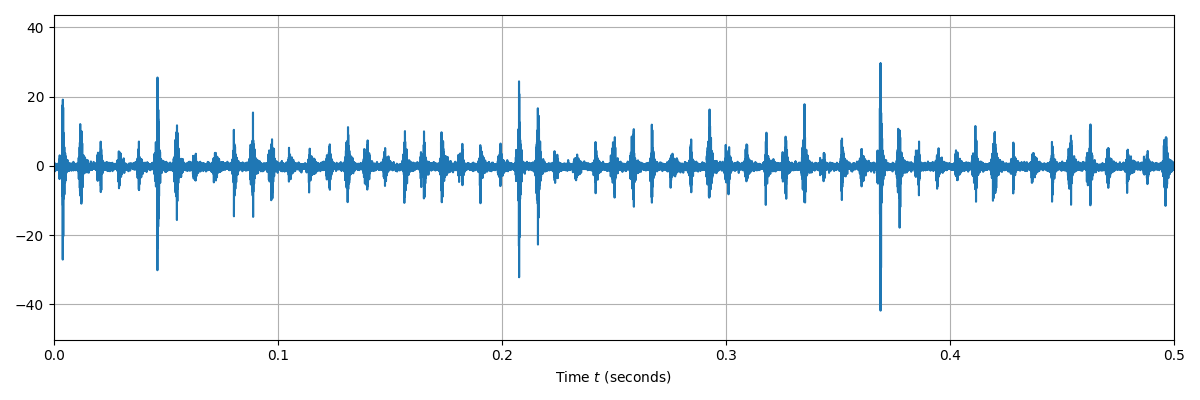

In [9]:
import matplotlib.pyplot as plt
plt.close(2); plt.figure(2, figsize=(12,4))

plt.plot(t, x)

plt.xlabel("Time $t$ (seconds)")
plt.xlim([0, 0.5])


* The signal of interest is *modulated* by high-frequency vibrations occurring at each bearing pass
    * Acquiring the signal of interest can be done by extracting the *envelope* of the vibration signal

#  Envelope detection

* Simple approach: smoothing of rectified signal

$$x_{\text{env}}[n] = |x[n]|*h_{\text{\Tiny{LP}}}[n]$$

(0.0, 0.5)

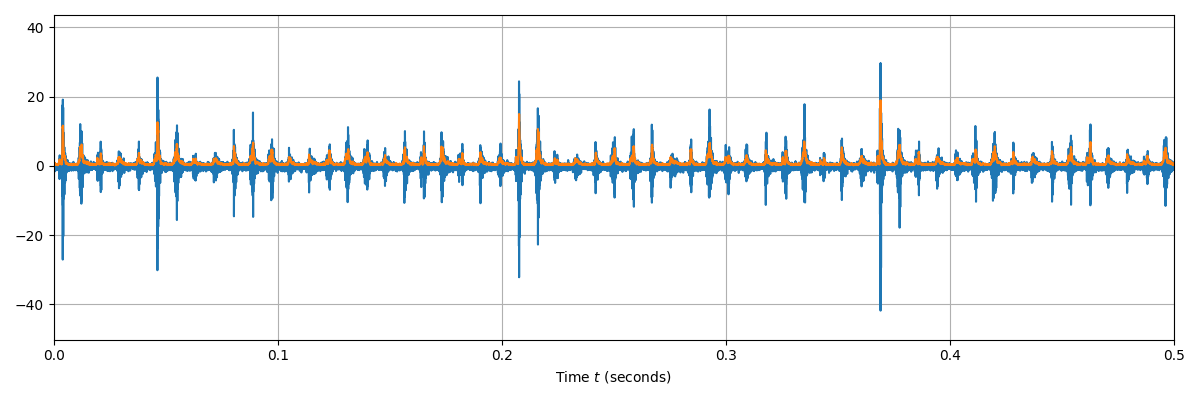

In [13]:
import matplotlib.pyplot as plt
h_LP = np.ones(11)/11
x_env = np.convolve(np.abs(x), h_LP, mode="same")

plt.close(3); plt.figure(3, figsize=(12,4))
plt.plot(t, x)
plt.plot(t, x_env)

plt.xlabel("Time $t$ (seconds)")
plt.xlim([0, 0.5])

* The better way: removing out the *negative frequency content* to obtain a *complex signal* with one-sided spectrum
    * Why? The magnitude of a *quadrature signal* is constant: $\left|x_{\text{\small{onesided}}}[n]\right| = \left|A \cdot e^{j\hat{\omega}n + \phi}\right|=A$

# The hilbert transform

* Special name for a filter with ideal frequency response:
$$H(\hat{\omega}) = \begin{cases} j, & \hat{\omega} > 0 \\ 0, & \hat{\omega} = 0 \\ -j, & \hat{\omega} < 0 \end{cases}$$
    * What does it do? Phase shifts all frequency components in the signal by $90^\circ$


* Combine unfiltered and filtered signal to create complex signal

<img src="figures/hilbert.svg" align="center" style="width: 60%; margin-left:100px">

* Turns any sinusoids into a quadrature signal: $\cos(\omega \cdot t) + j\cos(\omega \cdot t + 90^\circ) = e^{j\omega \cdot t}$

# Designing the Hilbert Filter

* Easiest solution: Use Remez Exchange

Text(0, 0.5, 'Phase response $\\angle H(f)$')

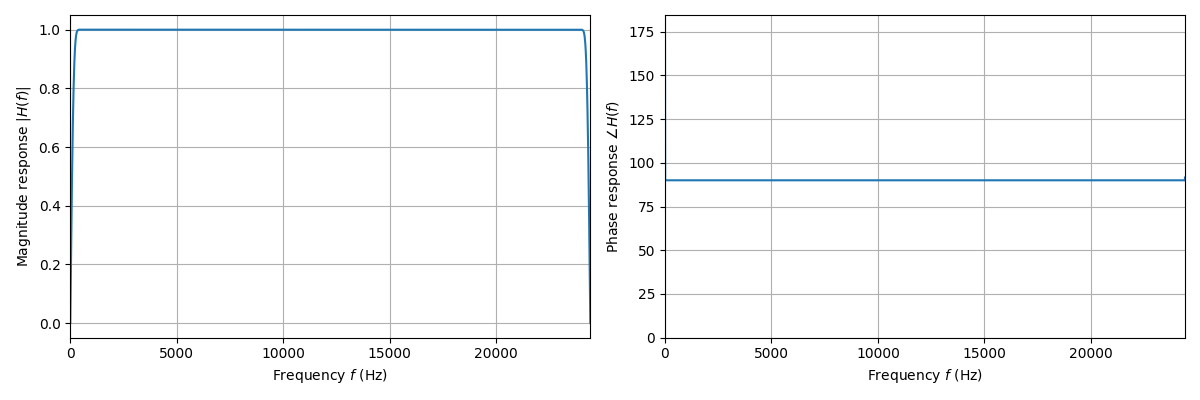

In [31]:
import numpy as np
import scipy.signal as sig
TW = 500 # Hz
h_env = sig.remez(numtaps=513, 
                  bands=[TW, fs/2-TW],
                  desired=[1],
                  fs=fs,
                  type='hilbert')
f, Hf = sig.freqz(h_env, worN = np.linspace(0, fs/2, 5001), fs=fs)
H_phase = np.unwrap(np.angle(Hf))
H_phase += 2*np.pi*f/fs*(513-1)/2
H_phase = np.rad2deg(H_phase)
plt.close(4); plt.figure(4, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(f, np.abs(Hf))
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("Magnitude response $|H(f)|$")
plt.subplot(1,2,2)
plt.plot(f, H_phase)
plt.ylim(ymin=0)
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("Phase response $\\angle H(f)$")

# Vibration signal envelope detection

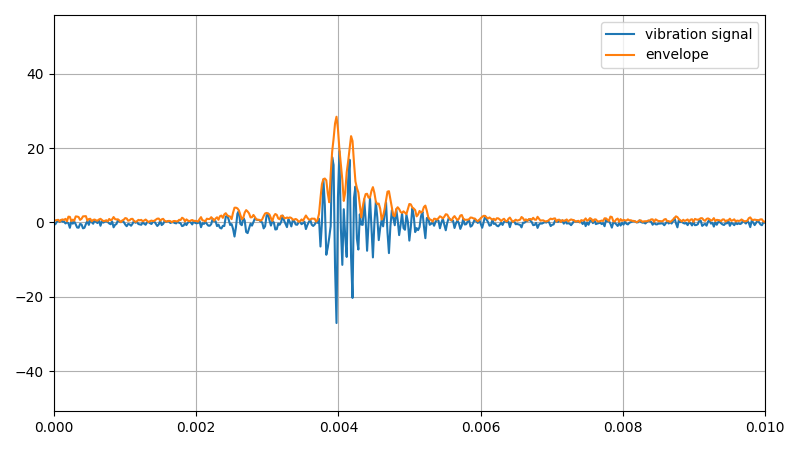

In [30]:
z = x + 1j*np.convolve(x, h_env, mode="same")
x_env = np.abs(z)

plt.close(5); plt.figure(5)
plt.plot(t, x, label="vibration signal")
plt.plot(t, x_env, label="envelope")
plt.xlim([0, 0.01])
plt.legend();

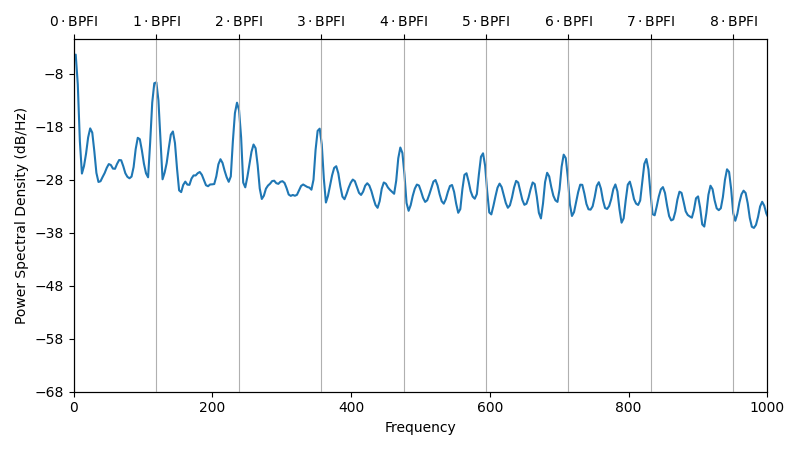

In [39]:
winsize=8192
f_max=1000
plt.close(6); plt.figure(6)
plt.psd(x_env, 
        NFFT=winsize,
        noverlap=winsize//2,
        pad_to = 2*winsize,
        Fs=fs,
        window=sig.windows.hamming(winsize));
plt.xlim([0, f_max])
plt.grid(False)
plt.twiny()
# Add ticks to BPFI and harmonics
plt.xticks(np.arange(0, fs/2, BPFI), ["$%d\\cdot \\text{BPFI}$"%(n) for n in np.arange(0, fs/2/BPFI)]);
plt.xlim([0, f_max])
plt.grid(True)